xESMF Test
================

### Basic Imports

In [1]:
import intake
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import xarray as xr
import xesmf as xe
import datetime
from clisops.core import subset
import clisops as cl
print("Using roocs/clisops in version %s" % cl.__version__)
print("Using xESMF in version %s" % xe.__version__)

xr.set_options(display_style='html')

Using roocs/clisops in version 0.3.1
Using xESMF in version 0.3.0


### Load the datasets

In [2]:
# Load intake catalogue
col_url = "/work/ik1017/Catalogs/mistral-cmip6.json"
col = intake.open_esm_datastore(col_url)

# Select tas_Amon and fx_areacella for LR and HR model resolution
#  and historical, ssp585
cat = col.search(activity_id=["CMIP", "ScenarioMIP"], 
                 source_id=["MPI-ESM1-2-HR", "MPI-ESM1-2-LR"],
                 experiment_id=["ssp585", "historical"], 
                 member_id="r1i1p1f1", 
                 variable_id=["tas", "areacella"],
                 table_id=["Amon", "fx"])

In [3]:
cat.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,dcpp_init_year,version,time_range,path
0,CMIP,MPI-M,MPI-ESM1-2-HR,historical,r1i1p1f1,Amon,tas,gn,NaN,v20190710,185001-185412,/mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/CMI...
1,CMIP,MPI-M,MPI-ESM1-2-HR,historical,r1i1p1f1,Amon,tas,gn,NaN,v20190710,185501-185912,/mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/CMI...
2,CMIP,MPI-M,MPI-ESM1-2-HR,historical,r1i1p1f1,Amon,tas,gn,NaN,v20190710,186001-186412,/mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/CMI...
3,CMIP,MPI-M,MPI-ESM1-2-HR,historical,r1i1p1f1,Amon,tas,gn,NaN,v20190710,186501-186912,/mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/CMI...
4,CMIP,MPI-M,MPI-ESM1-2-HR,historical,r1i1p1f1,Amon,tas,gn,NaN,v20190710,187001-187412,/mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/CMI...
...,...,...,...,...,...,...,...,...,...,...,...,...
64,ScenarioMIP,MPI-M,MPI-ESM1-2-LR,ssp585,r1i1p1f1,Amon,tas,gn,NaN,v20190710,203501-205412,/mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/Sce...
65,ScenarioMIP,MPI-M,MPI-ESM1-2-LR,ssp585,r1i1p1f1,Amon,tas,gn,NaN,v20190710,205501-207412,/mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/Sce...
66,ScenarioMIP,MPI-M,MPI-ESM1-2-LR,ssp585,r1i1p1f1,Amon,tas,gn,NaN,v20190710,207501-209412,/mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/Sce...
67,ScenarioMIP,MPI-M,MPI-ESM1-2-LR,ssp585,r1i1p1f1,Amon,tas,gn,NaN,v20190710,209501-210012,/mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/Sce...


In [4]:
dset_dict = cat.to_dataset_dict(cdf_kwargs={'chunks': {}, 'decode_times': True})

for dict_key in dset_dict.keys(): print(dict_key)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


CMIP.MPI-M.MPI-ESM1-2-HR.historical.fx.gn
ScenarioMIP.MPI-M.MPI-ESM1-2-LR.ssp585.fx.gn
CMIP.MPI-M.MPI-ESM1-2-HR.historical.Amon.gn
CMIP.MPI-M.MPI-ESM1-2-LR.historical.Amon.gn
ScenarioMIP.DKRZ.MPI-ESM1-2-HR.ssp585.fx.gn
ScenarioMIP.DKRZ.MPI-ESM1-2-HR.ssp585.Amon.gn
CMIP.MPI-M.MPI-ESM1-2-LR.historical.fx.gn
ScenarioMIP.MPI-M.MPI-ESM1-2-LR.ssp585.Amon.gn


In [5]:
# Select last 20 years of ssp585
ds_sspLR = dset_dict['ScenarioMIP.MPI-M.MPI-ESM1-2-LR.ssp585.Amon.gn'].sel(time=slice('2081', '2100'))
ds_sspHR = dset_dict['ScenarioMIP.DKRZ.MPI-ESM1-2-HR.ssp585.Amon.gn'].sel(time=slice('2081', '2100'))
# Select last 20 years of historical
ds_histLR = dset_dict['CMIP.MPI-M.MPI-ESM1-2-LR.historical.Amon.gn'].sel(time=slice('1995', '2014'))
ds_histHR = dset_dict['CMIP.MPI-M.MPI-ESM1-2-HR.historical.Amon.gn'].sel(time=slice('1995', '2014'))
# Select gridcell area
ds_gridLR = dset_dict['CMIP.MPI-M.MPI-ESM1-2-LR.historical.fx.gn']
ds_gridHR = dset_dict['CMIP.MPI-M.MPI-ESM1-2-HR.historical.fx.gn']

### Calculate Climatologies

In [6]:
ds_sspLR_cm = ds_sspLR.groupby('time.month').mean(['time'])
ds_sspHR_cm = ds_sspHR.groupby('time.month').mean(['time'])
ds_histLR_cm = ds_histLR.groupby('time.month').mean(['time'])
ds_histHR_cm = ds_histHR.groupby('time.month').mean(['time'])

### Calculate temperature change between 1995-2014 and 2081-2100

In [7]:
ds_dT_LR=ds_sspLR_cm-ds_histLR_cm
ds_dT_HR=ds_sspHR_cm-ds_histHR_cm

### Plot the results

In [8]:
from calendar import month_name

SMALL_SIZE = 10
MEDIUM_SIZE = 16
BIGGER_SIZE = 20
plt.rc('font', size=SMALL_SIZE)         # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)   # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)   # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)   # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)   # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)   # legend fontsize
plt.rc('figure', titlesize=SMALL_SIZE)  # fontsize of the figure title

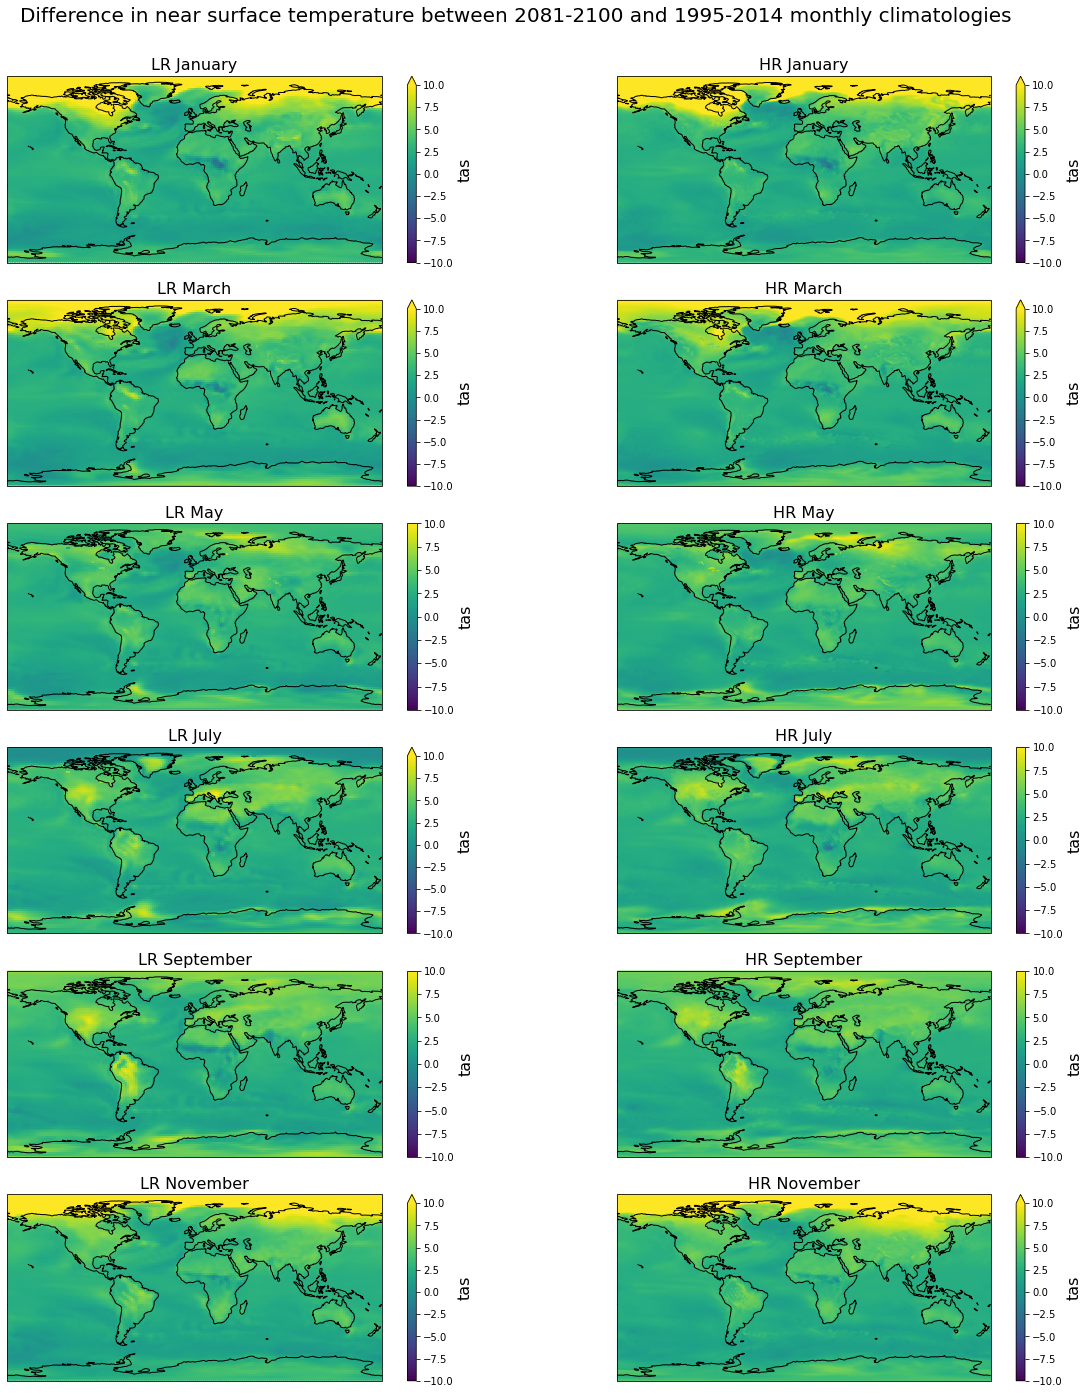

In [9]:
months=list(range(0,12,2))

fig, axes = plt.subplots(ncols=2, nrows=len(months), figsize=(20, 4*len(months)), 
                         subplot_kw={'projection': ccrs.PlateCarree()})

plt.suptitle("Difference in near surface temperature between 2081-2100 and 1995-2014 monthly climatologies", 
             y=0.92, fontsize=BIGGER_SIZE)

for month in months:
    axes[months.index(month),0].coastlines();
    axes[months.index(month),1].coastlines();    
    ds_dT_LR.tas.isel(month=month).plot(ax=axes[months.index(month),0], vmin=-10, vmax=10)
    ds_dT_HR.tas.isel(month=month).plot(ax=axes[months.index(month),1], vmin=-10, vmax=10)
    axes[months.index(month),0].title.set_text("LR "+month_name[month+1])
    axes[months.index(month),1].title.set_text("HR "+month_name[month+1])

### Perform Regridding / Upscaling of HR to LR Grid

In [10]:
method_list = ['bilinear','nearest_s2d', 'conservative', 'patch']

def regrid(ds_in, ds_out, dr_in, method):
    """Convenience function for one-time regridding"""
    regridder = xe.Regridder(ds_in, ds_out, method, periodic=True)
    dr_out = regridder(dr_in)
    regridder.clean_weight_file()
    return dr_out

In [11]:
# Specify lat_b(nlat+1) and lon_b(nlat+1) from lat_bnds(nlat,2) and lon_bnds(nlon+2)
#   required by ESMF for conservative regridding
# https://github.com/JiaweiZhuang/xESMF/issues/74
# https://github.com/JiaweiZhuang/xESMF/issues/14#issuecomment-369686779

# Renaming alone is not sufficient
#rename_dict={"lat_bnds": "lat_b", "lon_bnds": "lon_b"}
#ds=ds.rename(rename_dict)

# for HR grid
lat_b=np.zeros(ds_sspHR["lat_bnds"].shape[0]+1, dtype="double")
lat_b[:-1]=ds_sspHR["lat_bnds"][:,0].values
lat_b[-1]=ds_sspHR["lat_bnds"][-1,1].values
lon_b=np.zeros(ds_sspHR["lon_bnds"].shape[0]+1, dtype="double")
lon_b[:-1]=ds_sspHR["lon_bnds"][:,0].values
lon_b[-1]=ds_sspHR["lon_bnds"][-1,1].values
ds_sspHR["lon_b"]=lon_b
ds_sspHR["lat_b"]=lat_b

# for LR grid
lat_b=np.zeros(ds_sspLR["lat_bnds"].shape[0]+1, dtype="double")
lat_b[:-1]=ds_sspLR["lat_bnds"][:,0].values
lat_b[-1]=ds_sspLR["lat_bnds"][-1,1].values
lon_b=np.zeros(ds_sspLR["lon_bnds"].shape[0]+1, dtype="double")
lon_b[:-1]=ds_sspLR["lon_bnds"][:,0].values
lon_b[-1]=ds_sspLR["lon_bnds"][-1,1].values
ds_sspLR["lon_b"]=lon_b
ds_sspLR["lat_b"]=lat_b

In [12]:
# Perform regridding
for method in method_list:
    %time ds_dT_LR["tas_"+method] = regrid(ds_sspHR, ds_sspLR, ds_dT_HR.tas, method)
    print('')

Create weight file: bilinear_192x384_96x192_peri.nc
Remove file bilinear_192x384_96x192_peri.nc
CPU times: user 1.34 s, sys: 93 ms, total: 1.43 s
Wall time: 24.8 s

Create weight file: nearest_s2d_192x384_96x192_peri.nc
Remove file nearest_s2d_192x384_96x192_peri.nc
CPU times: user 213 ms, sys: 20 ms, total: 233 ms
Wall time: 332 ms

Create weight file: conservative_192x384_96x192.nc
Remove file conservative_192x384_96x192.nc
CPU times: user 3.38 s, sys: 127 ms, total: 3.5 s
Wall time: 3.57 s

Create weight file: patch_192x384_96x192_peri.nc
Remove file patch_192x384_96x192_peri.nc
CPU times: user 11.4 s, sys: 226 ms, total: 11.6 s
Wall time: 11.7 s



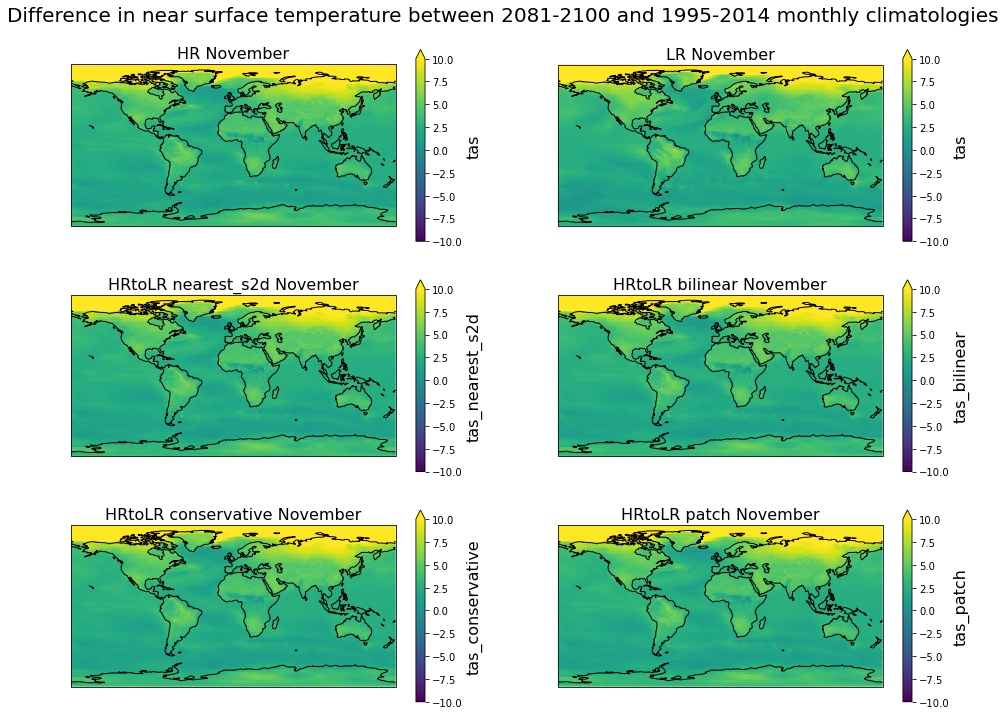

In [13]:
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(16, 12), 
                         subplot_kw={'projection': ccrs.PlateCarree()})
month=month
plt.suptitle("Difference in near surface temperature between 2081-2100 and 1995-2014 monthly climatologies", 
             y=0.93, fontsize=BIGGER_SIZE)

for ax in axes.flat:
    ax.coastlines()
ds_dT_HR["tas"].isel(month=month).plot(ax=axes[0,0], vmin=-10, vmax=10)
axes[0,0].title.set_text("HR "+month_name[month+1])
ds_dT_LR["tas"].isel(month=month).plot(ax=axes[0,1], vmin=-10, vmax=10)
axes[0,1].title.set_text("LR "+month_name[month+1])
ds_dT_LR["tas_nearest_s2d"].isel(month=month).plot(ax=axes[1,0], vmin=-10, vmax=10)
axes[1,0].title.set_text("HRtoLR nearest_s2d "+month_name[month+1])
ds_dT_LR["tas_bilinear"].isel(month=month).plot(ax=axes[1,1], vmin=-10, vmax=10)
axes[1,1].title.set_text("HRtoLR bilinear "+month_name[month+1])
ds_dT_LR["tas_conservative"].isel(month=month).plot(ax=axes[2,0], vmin=-10, vmax=10)
axes[2,0].title.set_text("HRtoLR conservative "+month_name[month+1])
ds_dT_LR["tas_patch"].isel(month=month).plot(ax=axes[2,1], vmin=-10, vmax=10)
axes[2,1].title.set_text("HRtoLR patch "+month_name[month+1])

### Compare global means

In [14]:
# Calculate global means of the regridded fields for each month 
#  and compute difference with respect to HR global mean

ds_dT_HR_glob=np.zeros(12, dtype="float32")
ds_dT_LR_glob=xr.Dataset(data_vars={"tas_"+method: ("time", np.zeros(12, dtype="float32")) for method in method_list},
                        coords={'month': ('time', np.arange(12))})

for month in range(12):
    ds_dT_HR_glob[month]=np.average(ds_dT_HR["tas"].isel(month=month, member_id=0), 
                                    weights=ds_gridHR["areacella"].isel(member_id=0))

    for method in method_list:
        ds_dT_LR_glob["tas_"+method][month]=np.average(ds_dT_LR["tas_"+method].isel(month=month, member_id=0), 
                                                       weights=ds_gridLR["areacella"].isel(member_id=0))

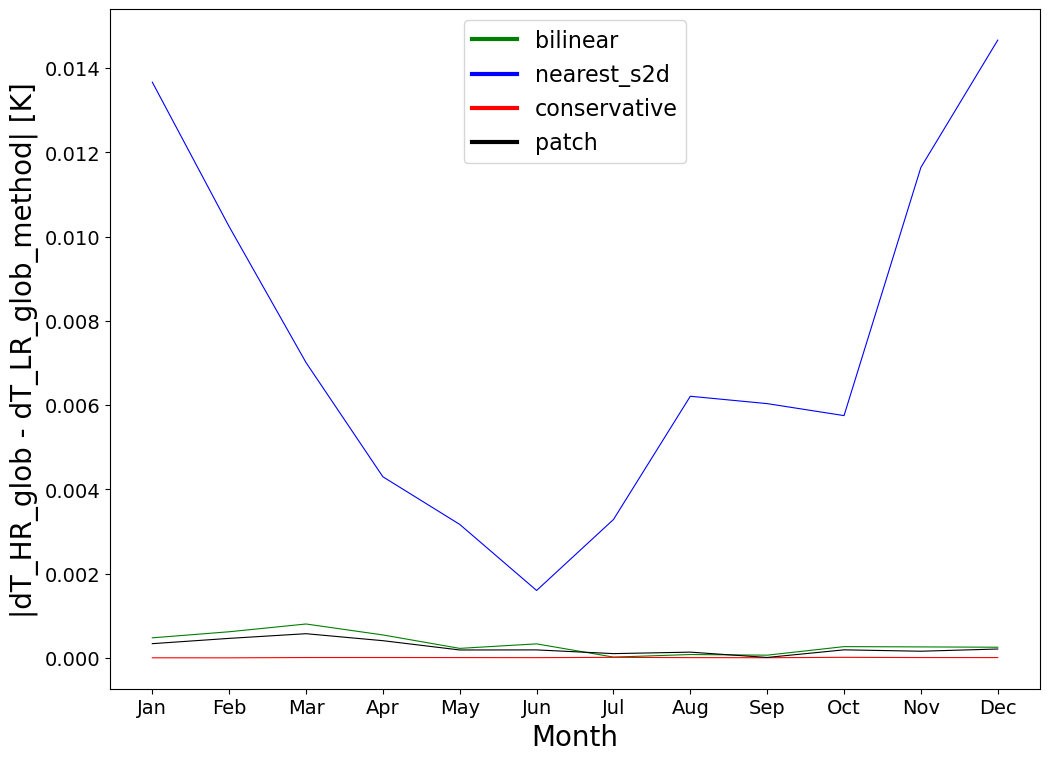

In [15]:
from matplotlib.lines import Line2D
from calendar import month_abbr

# Plot the results
fig = plt.figure(num=None, figsize=(12, 9), dpi=100, facecolor='w', edgecolor='k')
ax  = plt.axes()
colors=["green", "blue", "red", "black"]

for method in method_list:
    ax.plot(range(12), 
            abs(ds_dT_LR_glob["tas_"+method]-ds_dT_HR_glob), 
            color=colors[method_list.index(method)],
            linewidth=0.8)
    
# Axes and Titles
ax.tick_params(axis='both', which='major', labelsize=14)
plt.xticks(np.arange(12), [month_abbr[i+1] for i in range(12)])
ax.set_xlabel("Month", fontsize=20)
ax.set_ylabel("|dT_HR_glob - dT_LR_glob_method| [K]", fontsize=20)
#ax.set_title("", fontsize=20)
#fig.suptitle("", fontsize=30, fontweight="bold")

# Legend
lines=[Line2D([0], [0], color=c, linewidth=3) for c in colors]
plt.legend(lines, method_list, loc='best', fontsize=16)

### Differences with respect to conservatively regridded data

In [16]:
def plot_rdiff_for_month(ds, var, var_ref, month, force_cb_bounds=True):
    ds_rdiff=100.*(ds[var].isel(month=month)-
              ds[var_ref].isel(month=month))\
              /abs(ds[var_ref].isel(month=month))
    max_rdiff=np.amax(ds_rdiff.isel(member_id=0).values)
    min_rdiff=np.amin(ds_rdiff.isel(member_id=0).values)
    fig=plt.figure(figsize=(16,9))
    ax = plt.axes(projection=ccrs.PlateCarree())
    if force_cb_bounds!=True:
        vmin=-max([abs(min_rdiff), abs(max_rdiff)])
        vmax=-vmin
    else:
        vmin=-100
        vmax=100
    ds_rdiff.isel(member_id=0).plot.pcolormesh(ax=ax, 
                                               vmin=vmin, 
                                               vmax=vmax)
    ax.coastlines()
    ax.title.set_text("%s - Relative Difference of %s with respect to %s [%%]" %(month_name[month+1], var, var_ref))
    
    print("Maximum relative difference: %f %%" % (max_rdiff))
    print("Minimum relative difference %f %%" % (min_rdiff))

Maximum relative difference: 387.816643 %
Minimum relative difference -1304.511260 %


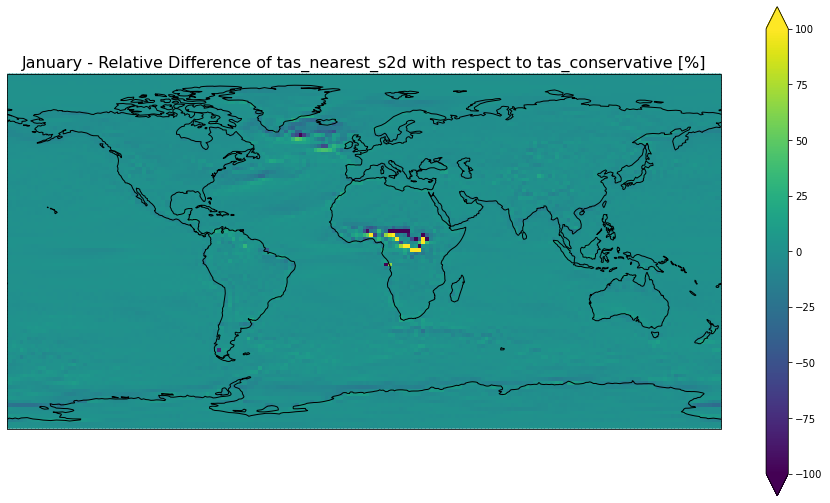

In [17]:
plot_rdiff_for_month(ds_dT_LR, "tas_nearest_s2d", "tas_conservative", 0)

Maximum relative difference: 55.449834 %
Minimum relative difference -157.247844 %


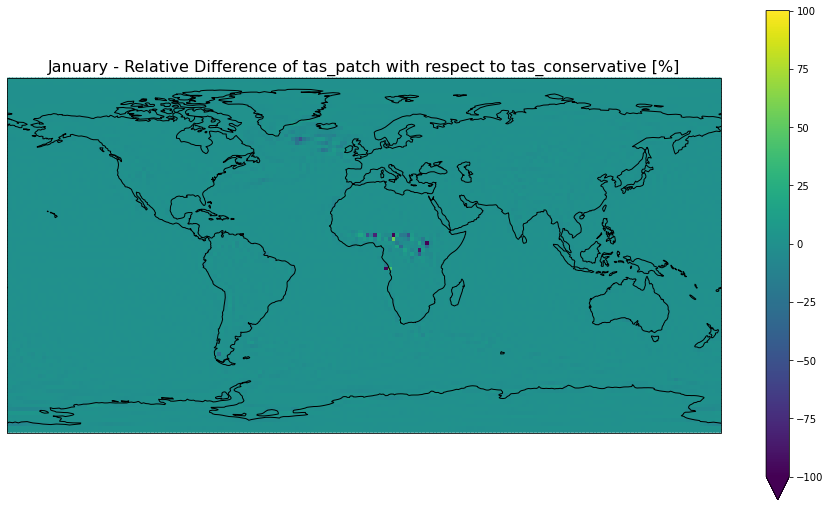

In [18]:
plot_rdiff_for_month(ds_dT_LR, "tas_patch", "tas_conservative", 0)

Maximum relative difference: 103.147440 %
Minimum relative difference -171.290467 %


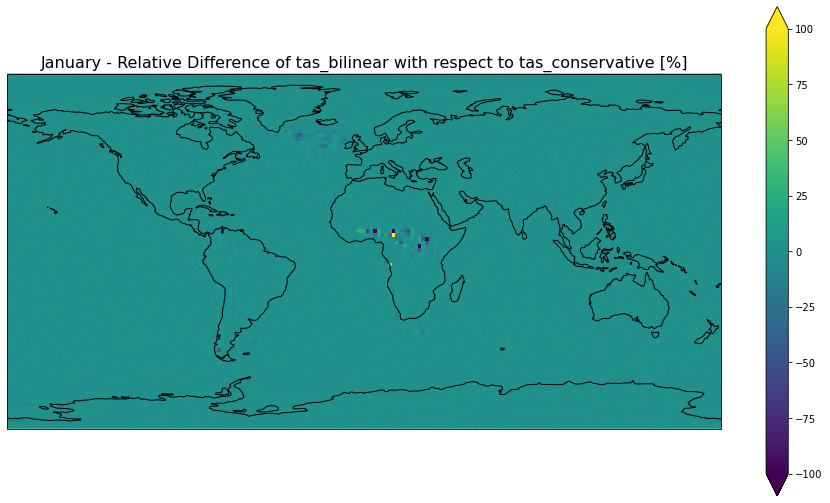

In [19]:
plot_rdiff_for_month(ds_dT_LR, "tas_bilinear", "tas_conservative", 0)